## Code for the generations on C4 dataset are in the "Watermark Paper Reproduction C4 Dataset" file
## Code for the generations on XSUM dataset are in the "Watermark Generation - Xsum Dataset" file
### All file paths are taken according to my local filesystem. If you want to rerun this notebook successfully mount your drive to the colab, link the drive folder provided in the report, and adjust the paths accordingly

In [ ]:
import pandas as pd
from json import dumps, loads
import os
import matplotlib.pyplot as plt
import statistics

In [ ]:
# function to calculate average z_score at token T
def avg_z_at_T(detectors):
    z_scores_T = []
    for x in detectors:
        x1=x[x.find("tensor([")+len("tensor(["):x.find(", 'prediction'")][:-2]
        x1=x1.replace(" ","")
        z_score_at_T = []
        for i in x1.split("\n"):
            z_score_at_T+=i.split(",")
        z_score_at_T = [float(i) for i in z_score_at_T if i!='\r']
        z_scores_T.append(z_score_at_T)
    t_len = max([len(x) for x in z_scores_T])
    avg_z_T = []
    for i in range(t_len):
        avg_z_i = []
        for j in range(len(z_scores_T)):
            if i<len(z_scores_T[j]):
                avg_z_i.append(z_scores_T[j][i])
        avg_z_T.append(sum(avg_z_i)/len(avg_z_i))
    return avg_z_T

In [ ]:
deltas = [0.0, 1.0, 2.0, 5.0, 10.0]
gammas = [0.1, 0.25, 0.5, 0.75, 0.9]
d = {}
avg_z_T = {}
z_pred = {}
for delta in deltas:
    for gamma in gammas:
        df = pd.read_csv(f"csv_files/delta_{delta}_gamma_{gamma}.csv")
        detectors = df['detector'].tolist()
        avg_z_score = sum([float(l[l.find("z_score': ")+len("z_score': "):l.find(", 'p_value")]) for l in detectors])/len(detectors)
        z_pred[(delta, gamma)] = [l[l.find("'prediction': ")+len("'prediction': "):l.find("}")] for l in detectors]
        avg_ppl = sum(df['perplexity'])/len(df['perplexity'])
        d[(delta, gamma)] = [avg_z_score, avg_ppl]
        avg_z_T[(delta, gamma)] = avg_z_at_T(df['detector'].tolist())

## Figure 2(left) from the paper

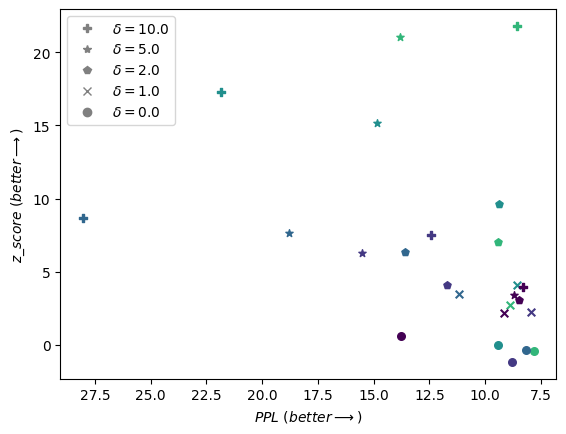

In [ ]:
delta_marker = {0.0: 'o', 1.0: 'x', 2.0: 'p', 5.0: '*', 10.0: 'P'}
gamma_colors = {
    0.1: (0.196571, 0.711827, 0.479221), # light green
    0.25: (0.129933, 0.559582, 0.551864), # green
    0.5: (0.192357, 0.403199, 0.555836), # teal
    0.75: (0.267968, 0.223549, 0.512008), # navy blue
    0.9: (0.267004, 0.004874, 0.329415)} # dark blue

for k, v in d.items():
    plt.scatter(v[1], v[0], marker=delta_marker[k[0]], s=30, color=gamma_colors[k[1]])
deltas = [10.0, 5.0, 2.0, 1.0, 0.0]
gammas = [0.1, 0.25, 0.5, 0.75, 0.9]
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f(delta_marker[delta], "gray") for delta in deltas]
legends = [f"$\\delta={delta}$" for delta in deltas]
plt.gca().invert_xaxis()
plt.legend(handles, legends)
plt.ylabel(r"$z\_score\ (better \longrightarrow)$")
plt.xlabel(r"$PPL\ (better \longrightarrow)$")
plt.show()

## Figure 3(a) and 3(b) from the paper

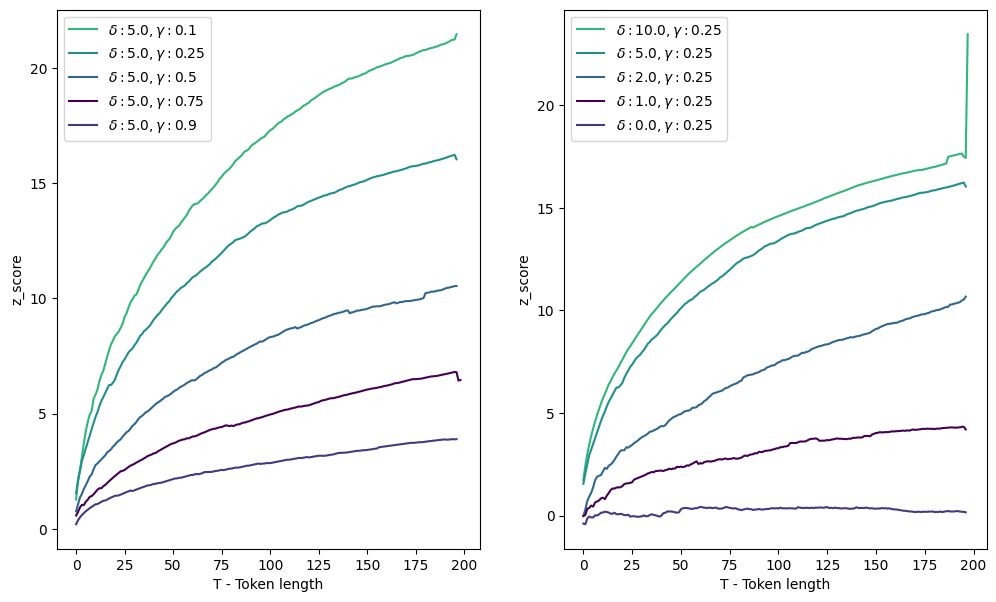

In [ ]:
delta_colors = {
    0.0: (0.267968, 0.223549, 0.512008),
    1.0: (0.267004, 0.004874, 0.329415),
    2.0: (0.192357, 0.403199, 0.555836),
    5.0: (0.129933, 0.559582, 0.551864),
    10.0: (0.196571, 0.711827, 0.479221)}
gamma_colors = {
    0.1: (0.196571, 0.711827, 0.479221),
    0.25: (0.129933, 0.559582, 0.551864),
    0.5: (0.192357, 0.403199, 0.555836),
    0.75: (0.267004, 0.004874, 0.329415),
    0.9: (0.267968, 0.223549, 0.512008)}
gammas = [0.1, 0.25, 0.5, 0.75, 0.9]
legends = []
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
for gamma in gammas:
    plt.plot(avg_z_T[(5.0, gamma)], color=gamma_colors[gamma])
    legends.append(f'$\\delta:5.0, \\gamma:{gamma}$')
plt.ylabel("z_score")
plt.xlabel("T - Token length")
plt.legend(legends)

plt.subplot(1, 2, 2)
deltas = [10.0, 5.0, 2.0, 1.0, 0.0]
legends = []
for delta in deltas:
    plt.plot(avg_z_T[(delta, 0.25)], color=delta_colors[delta])
    legends.append(f'$\\delta:{delta}, \\gamma:0.25$')
plt.ylabel("z_score")
plt.xlabel("T - Token length")
plt.legend(legends)
plt.show()

In [ ]:
deltas = [0.0, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
gamma = 0.25
n_beams=[1, 4, 8]
d_beams = {}
avg_z_T_beams = {}
for delta in deltas:
    for beam in n_beams:
        file = f"delta_{delta}_gamma_{gamma}_beams{beam}.csv"
        if file in os.listdir('csv_files/'):
            df = pd.read_csv('csv_files/'+file)
            detectors = df['detector'].tolist()
            avg_z_score = sum([float(l.split(",")[3].split(":")[1][1:]) for l in detectors])/len(detectors)
            avg_ppl = sum(df['perplexity'])/len(df['perplexity'])
            d_beams[(delta, gamma, beam)] = [avg_z_score, avg_ppl]
            avg_z_T_beams[(delta, gamma, beam)] = avg_z_at_T(df['detector'].tolist())

delta_0.0_gamma_0.25_beams1.csv
delta_0.0_gamma_0.25_beams4.csv
delta_0.0_gamma_0.25_beams8.csv
delta_0.1_gamma_0.25_beams1.csv
delta_0.1_gamma_0.25_beams4.csv
delta_0.1_gamma_0.25_beams8.csv
delta_0.5_gamma_0.25_beams1.csv
delta_0.5_gamma_0.25_beams4.csv
delta_1.0_gamma_0.25_beams1.csv
delta_2.0_gamma_0.25_beams1.csv
delta_5.0_gamma_0.25_beams1.csv
delta_10.0_gamma_0.25_beams1.csv


## Figure 2(right) partial from the paper

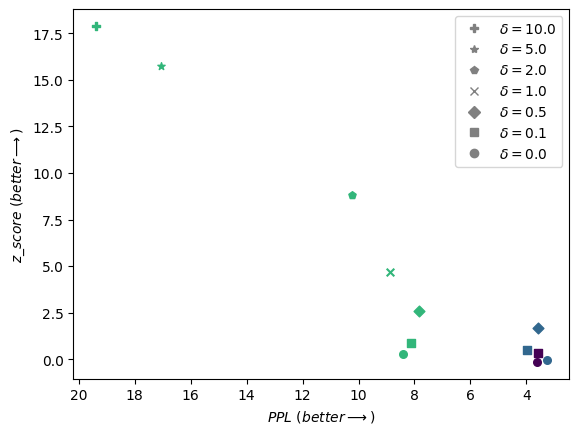

In [ ]:
delta_marker = {0.0: 'o', 0.1: 's', 0.5: 'D', 1.0: 'x', 2.0: 'p', 5.0: '*', 10.0: 'P'}
nbeams_colors = {
    1: (0.196571, 0.711827, 0.479221),
    4: (0.192357, 0.403199, 0.555836),
    8: (0.267004, 0.004874, 0.329415)}

for k, v in d_beams.items():
    plt.scatter(v[1], v[0], marker=delta_marker[k[0]], s=30, color=nbeams_colors[k[2]])
deltas = [10.0, 5.0, 2.0, 1.0, 0.5, 0.1, 0.0]
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f(delta_marker[delta], "gray") for delta in deltas]
legends = [f"$\\delta={delta}$" for delta in deltas]
plt.gca().invert_xaxis()
plt.legend(handles, legends)
plt.ylabel(r"$z\_score\ (better \longrightarrow)$")
plt.xlabel(r"$PPL\ (better \longrightarrow)$")
plt.show()

## Figure 3(c) from the paper(n_beams=8) with n_beams=1

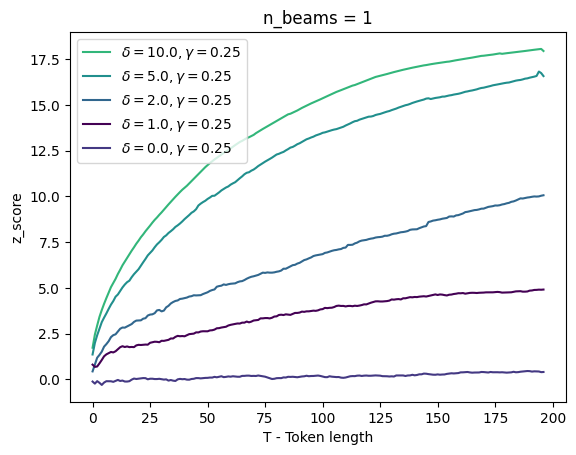

In [ ]:
# plot of z_score vs Token length for n_beams = 1
deltas = [10.0, 5.0, 2.0, 1.0, 0.0]
legends = []
for delta in deltas:
    plt.plot(avg_z_T_beams[(delta, 0.25, 1)], color=delta_colors[delta])
    legends.append(f'$\\delta={delta}, \\gamma=0.25$')
plt.ylabel("z_score")
plt.xlabel("T - Token length")
plt.legend(legends)
plt.title("n_beams = 1")
plt.show()

In [ ]:
# TPR and FNR values for the pairs given in the paper
deltas=[1.0, 2.0, 5.0]
gammas = [0.25, 0.5]
classification_metrics = {}
for delta in deltas:
    for gamma in gammas:
        tpr=fnr=0
        for pred in z_pred[(delta, gamma)]:
            pred = pred.split(',')[0]
            if pred == 'True':
                tpr+=1
            else:
                fnr+=1
        classification_metrics[(delta, gamma)] = (tpr/25, fnr/25)

## Table 2 from the paper

In [ ]:
print("          Z = 4.0           ")
print("delta    gamma    TPR    FNR")
for k, v in classification_metrics.items():
    print(f"{k[0]}    {k[1]}     {v[0]}    {v[1]}")

          Z = 4.0           
delta    gamma    TPR    FNR
1.0    0.25     0.56    0.44
1.0    0.5     0.32    0.68
2.0    0.25     0.96    0.04
2.0    0.5     0.84    0.16
5.0    0.25     1.0    0.0
5.0    0.5     0.84    0.16


# XSUM Dataset generations

In [ ]:
df = pd.read_csv("csv_files/delta_10.0_gamma_0.25_xsum.csv")
df[["document", "summary", "decoded_w_bl", "z_score", "perplexity"]].head()

,document,summary,decoded_w_bl,z_score,perplexity
0,Four members of the Connors family from Rumney...,"Claims two men were forced into labour, beaten...",Want to receive the latest court cases straig...,14.774082,6.703250
1,Her Majesty's Crown Prosecution Service Inspec...,The Crown Prosecution Service in Wales has bee...,This is a short version of what to expect at ...,21.957425,29.563730
2,"Ten thousand miles away, though, in his adopte...",He's been immortalized in song and had babies ...,"is a series of previews of upcoming events, c...",24.083754,41.265766
3,Police launched a manhunt after a man armed wi...,"A jeweller has said he ""chased"" an armed robbe...",The Police is on a mission and you are their ...,15.000000,4.633297
4,Sabah al-Numan told the BBC that many IS fight...,Iraqi forces fighting so-called Islamic State ...,by Mark Harris is a weekly series summarise c...,10.392305,141.076630


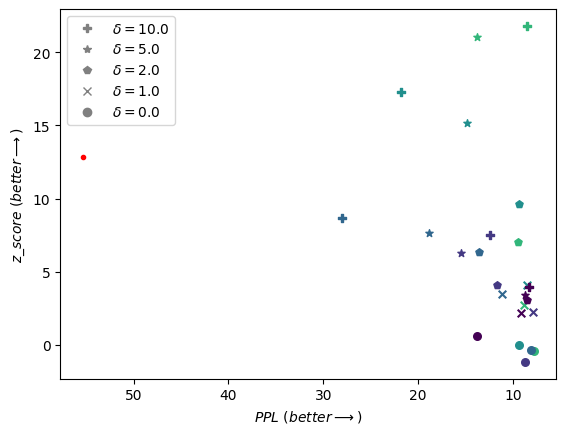

In [ ]:
# Plot the avg z_score vs avg ppl for the x_sum sequences with multinomial sampling and its related c4 dataset file
delta_marker = {0.0: 'o', 1.0: 'x', 2.0: 'p', 5.0: '*', 10.0: 'P'}
gamma_colors = {
    0.1: (0.196571, 0.711827, 0.479221), # light green
    0.25: (0.129933, 0.559582, 0.551864), # teal
    0.5: (0.192357, 0.403199, 0.555836),
    0.75: (0.267968, 0.223549, 0.512008),
    0.9: (0.267004, 0.004874, 0.329415)}

for k, v in d.items():
    plt.scatter(v[1], v[0], marker=delta_marker[k[0]], s=30, color=gamma_colors[k[1]])
plt.scatter(statistics.mean(df['perplexity'].tolist()), statistics.mean(df['z_score'].tolist()), color='red', marker='.')
deltas = [10.0, 5.0, 2.0, 1.0, 0.0]
gammas = [0.1, 0.25, 0.5, 0.75, 0.9]
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f(delta_marker[delta], "gray") for delta in deltas]
legends = [f"$\\delta={delta}$" for delta in deltas]
plt.gca().invert_xaxis()
plt.legend(handles, legends)
plt.ylabel(r"$z\_score\ (better \longrightarrow)$")
plt.xlabel(r"$PPL\ (better \longrightarrow)$")
plt.show()

### As the plot above shows the average perplexity and average z_score of the xsum sequences varies significantly compared to the sequences from C4 dataset

In [ ]:
# beam search implementation
df = pd.read_csv("csv_files/delta_10.0_gamma_0.25_beams8_xsum.csv")
df[["document", "summary", "decoded_w_bl", "z_score", "perplexity"]].head()

,document,summary,decoded_w_bl,z_score,perplexity
0,Four members of the Connors family from Rumney...,"Claims two men were forced into labour, beaten...",Want to receive the short version of what mig...,9.949874,1.944660
1,Her Majesty's Crown Prosecution Service Inspec...,The Crown Prosecution Service in Wales has bee...,Want to receive the latest Welsh court cases ...,11.489125,3.980324
2,"Ten thousand miles away, though, in his adopte...",He's been immortalized in song and had babies ...,"is a series of short stories, each featuring ...",11.537481,2.033908
3,Police launched a manhunt after a man armed wi...,"A jeweller has said he ""chased"" an armed robbe...","is a series of short stories, each featuring ...",13.190906,2.409870
4,Sabah al-Numan told the BBC that many IS fight...,Iraqi forces fighting so-called Islamic State ...,The BBC is not allowed to provide a more deta...,6.928203,1.380829


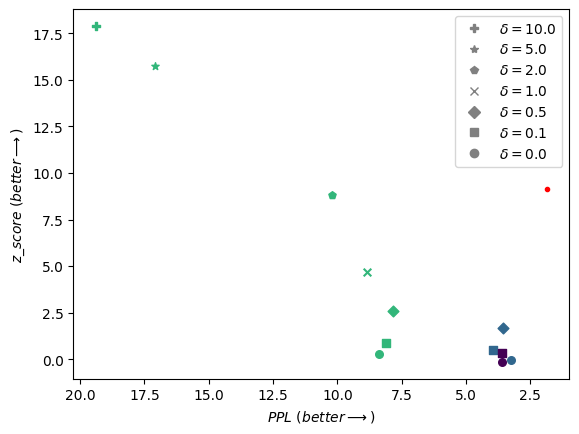

In [ ]:
# Plot the avg z_score vs avg ppl for the x_sum sequences with beam search and its related c4 dataset file
delta_marker = {0.0: 'o', 0.1: 's', 0.5: 'D', 1.0: 'x', 2.0: 'p', 5.0: '*', 10.0: 'P'}
nbeams_colors = {
    1: (0.196571, 0.711827, 0.479221),
    4: (0.192357, 0.403199, 0.555836),
    8: (0.267004, 0.004874, 0.329415)}

for k, v in d_beams.items():
    plt.scatter(v[1], v[0], marker=delta_marker[k[0]], s=30, color=nbeams_colors[k[2]])
plt.scatter(statistics.mean(df['perplexity'].tolist()), statistics.mean(df['z_score'].tolist()), color='red', marker='.')
deltas = [10.0, 5.0, 2.0, 1.0, 0.5, 0.1, 0.0]
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f(delta_marker[delta], "gray") for delta in deltas]
legends = [f"$\\delta={delta}$" for delta in deltas]
plt.gca().invert_xaxis()
plt.legend(handles, legends)
plt.ylabel(r"$z\_score\ (better \longrightarrow)$")
plt.xlabel(r"$PPL\ (better \longrightarrow)$")
plt.show()

### When compared to the original Figure 2(right) from the paper the results for this generation with beam search shows similar perplexity but the z_score however is less.